# (27) CIFAR

**Motivation**: Extract random patches from CIFAR10 to get to ```CIFAR10_PATCHES``` dataset. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.dataset import make_dataset
from utils.imgproc import xtract_patches_random, do_process
from figures.imgs import plot_weights

### Load dataset

In [3]:
%%time

trn, vld = make_dataset(
    dataset='CIFAR10',
    load_dir='/home/hadi/Datasets',
    device=None,
    grey=True,
)
dataset = {'trn': trn, 'vld': vld}

CPU times: user 438 ms, sys: 108 ms, total: 547 ms
Wall time: 547 ms


### Xtract patches

In [4]:
%%time

patches = {
    k: xtract_patches_random(
        dataset=ds,
        npix=20,
        n_patches=4,
    ) for k, ds in dataset.items()
}

CPU times: user 15.7 s, sys: 528 ms, total: 16.3 s
Wall time: 9.45 s


In [5]:
print({k: v.shape for k, v in patches.items()})

{'trn': torch.Size([200000, 1, 20, 20]), 'vld': torch.Size([40000, 1, 20, 20])}

### Whiten + Contrans nrm + Zscore

In [6]:
%%time

processed = {
    k: do_process(
        stim=x.cuda(),
        crop_size=2,
    ) for k, x in patches.items()
}

CPU times: user 5.36 s, sys: 308 ms, total: 5.67 s
Wall time: 665 ms


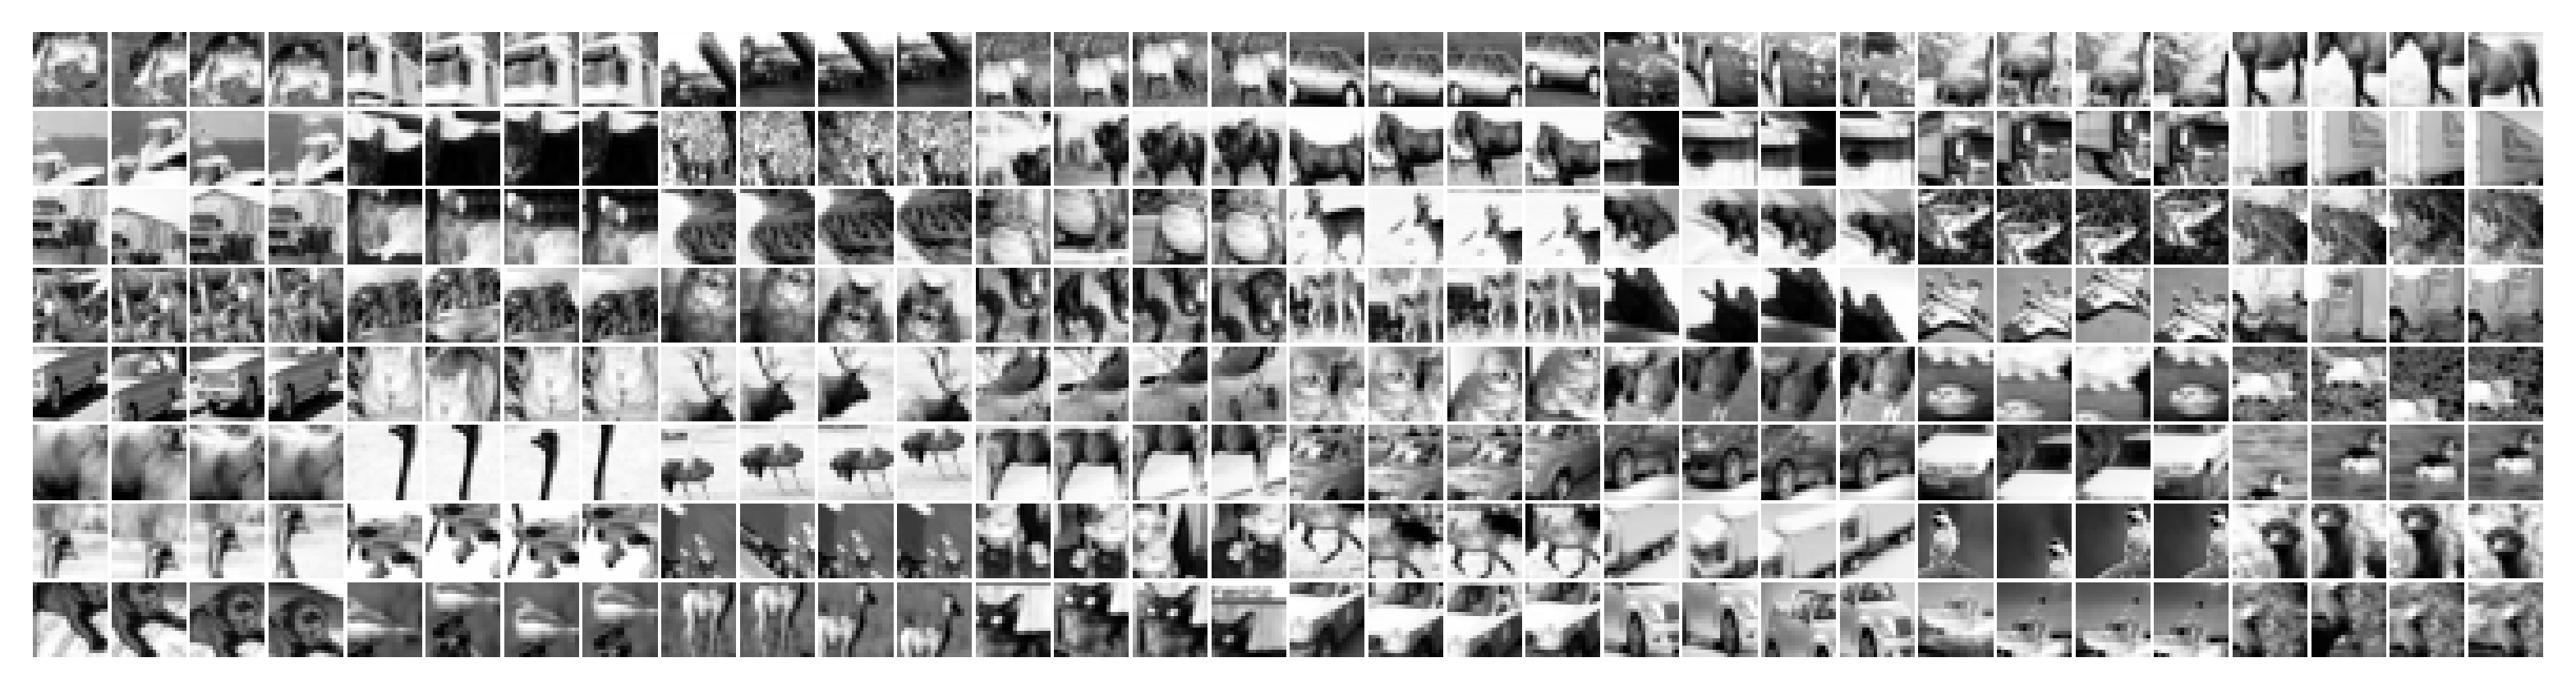

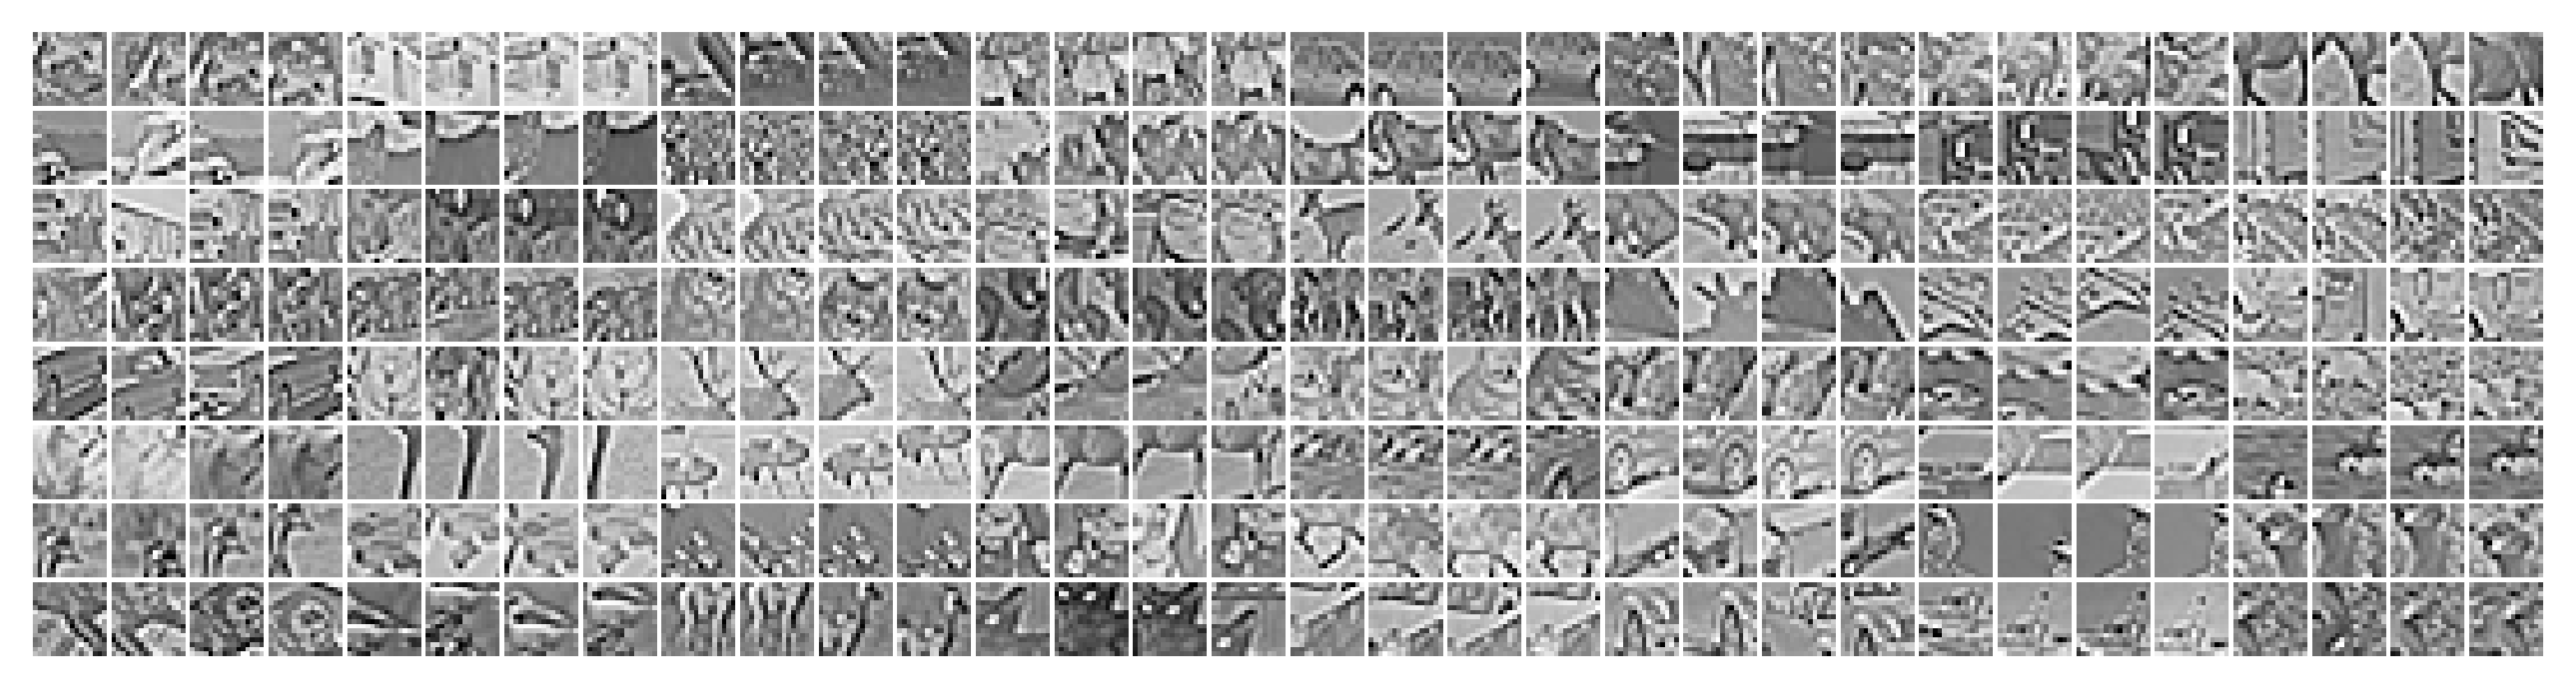

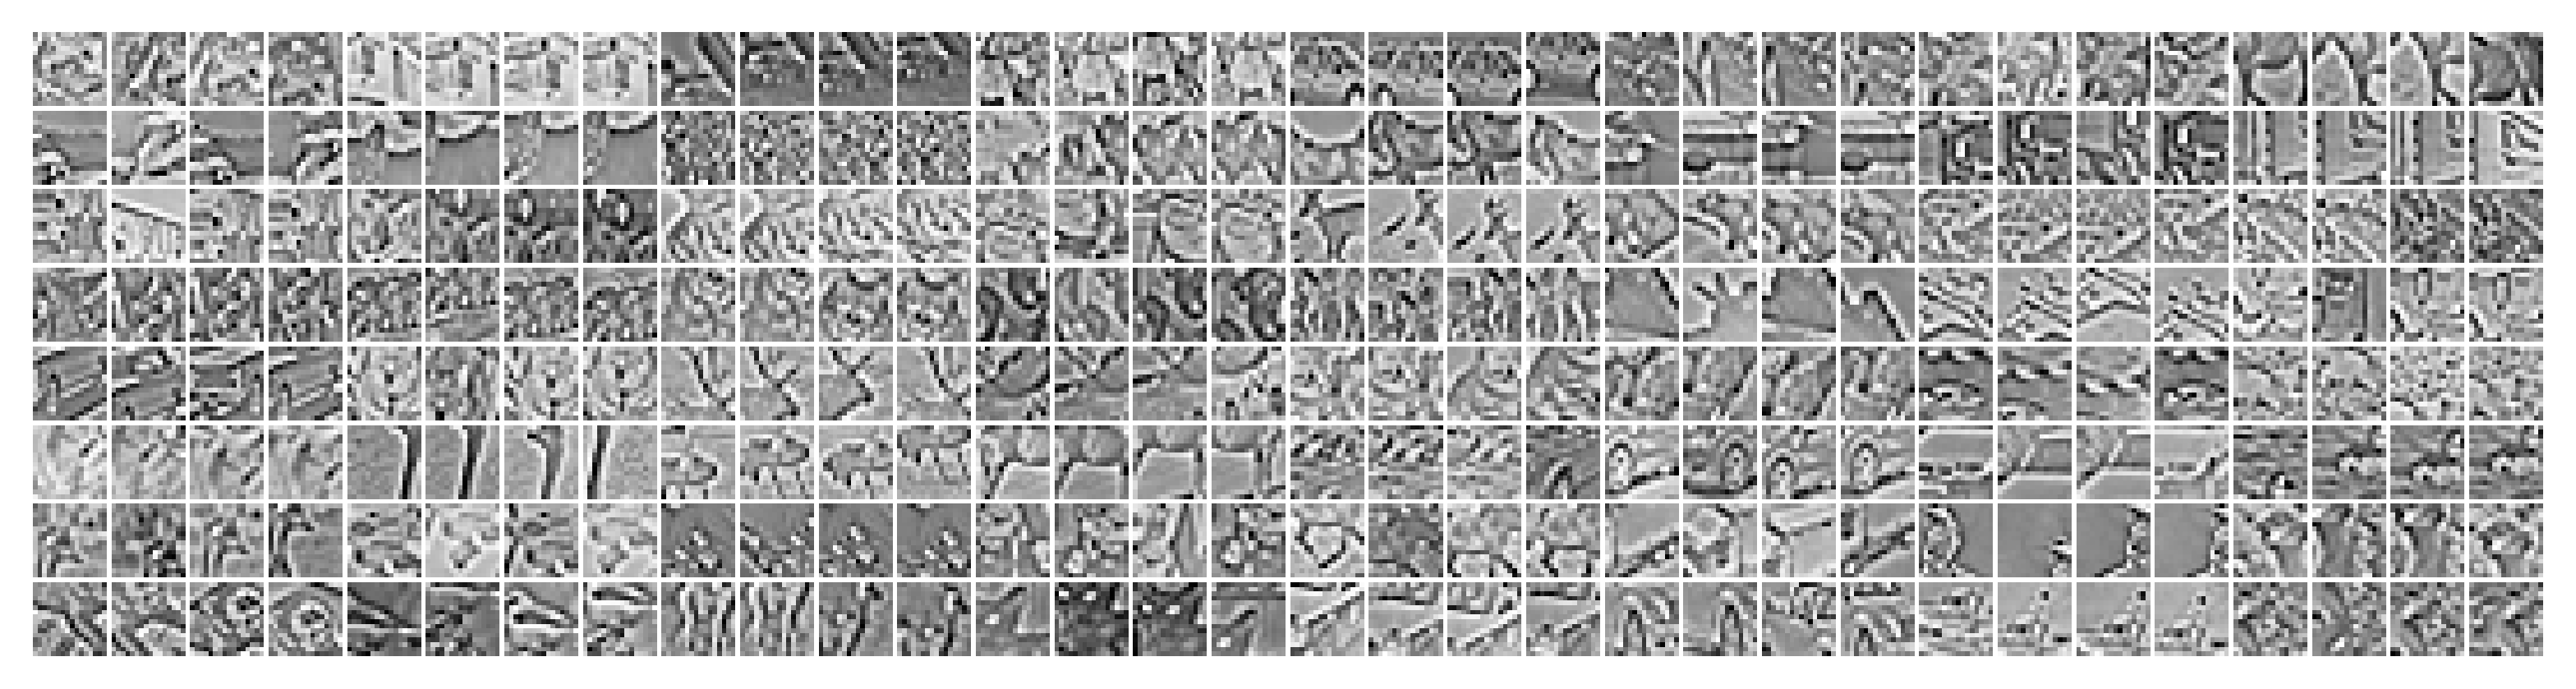

In [7]:
_ = plot_weights(patches['trn'].squeeze()[:256], nrows=8, dpi=400)
_ = plot_weights(processed['trn'][0].squeeze()[:256], nrows=8, dpi=400)
_ = plot_weights(processed['trn'][2].squeeze()[:256], nrows=8, dpi=400)

In [8]:
processed['trn'][2].shape

torch.Size([200000, 1, 16, 16])

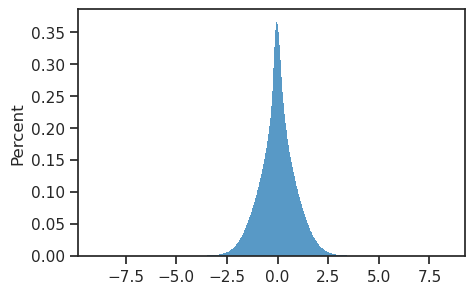

In [10]:
sns.histplot(to_np(processed['trn'][2]).ravel(), stat='percent');

## Save

In [11]:
path = '/home/hadi/Datasets/CIFAR10'
path = pjoin(path, 'xtract16')

for k, items in processed.items():
    save_dir = pjoin(path, k)
    os.makedirs(save_dir, exist_ok=True)
    
    save_dict = {
        'patches': to_np(patches[k]),
        'wt': to_np(items[0]),
        'wt_cn': to_np(items[1]),
        'processed': to_np(items[2]),
    }
    for fname, obj in save_dict.items():
        save_obj(
            obj=obj,
            file_name=fname,
            save_dir=save_dir,
            verbose=True,
            mode='npy',
        )

[PROGRESS] 'patches.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'wt.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'wt_cn.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'processed.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/trn

[PROGRESS] 'patches.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'wt.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'wt_cn.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

[PROGRESS] 'processed.npy' saved at
/home/hadi/Datasets/CIFAR10/xtract16/vld

In [12]:
to_np(patches['trn']).dtype, to_np(processed['trn'][2]).dtype

(dtype('float32'), dtype('float32'))

## Try loading (after saving is done above)

In [13]:
trn, vld = make_dataset(
    dataset='CIFAR10_PATCHES',
    load_dir='/home/hadi/Datasets',
    device=torch.device('cuda:0'),
)

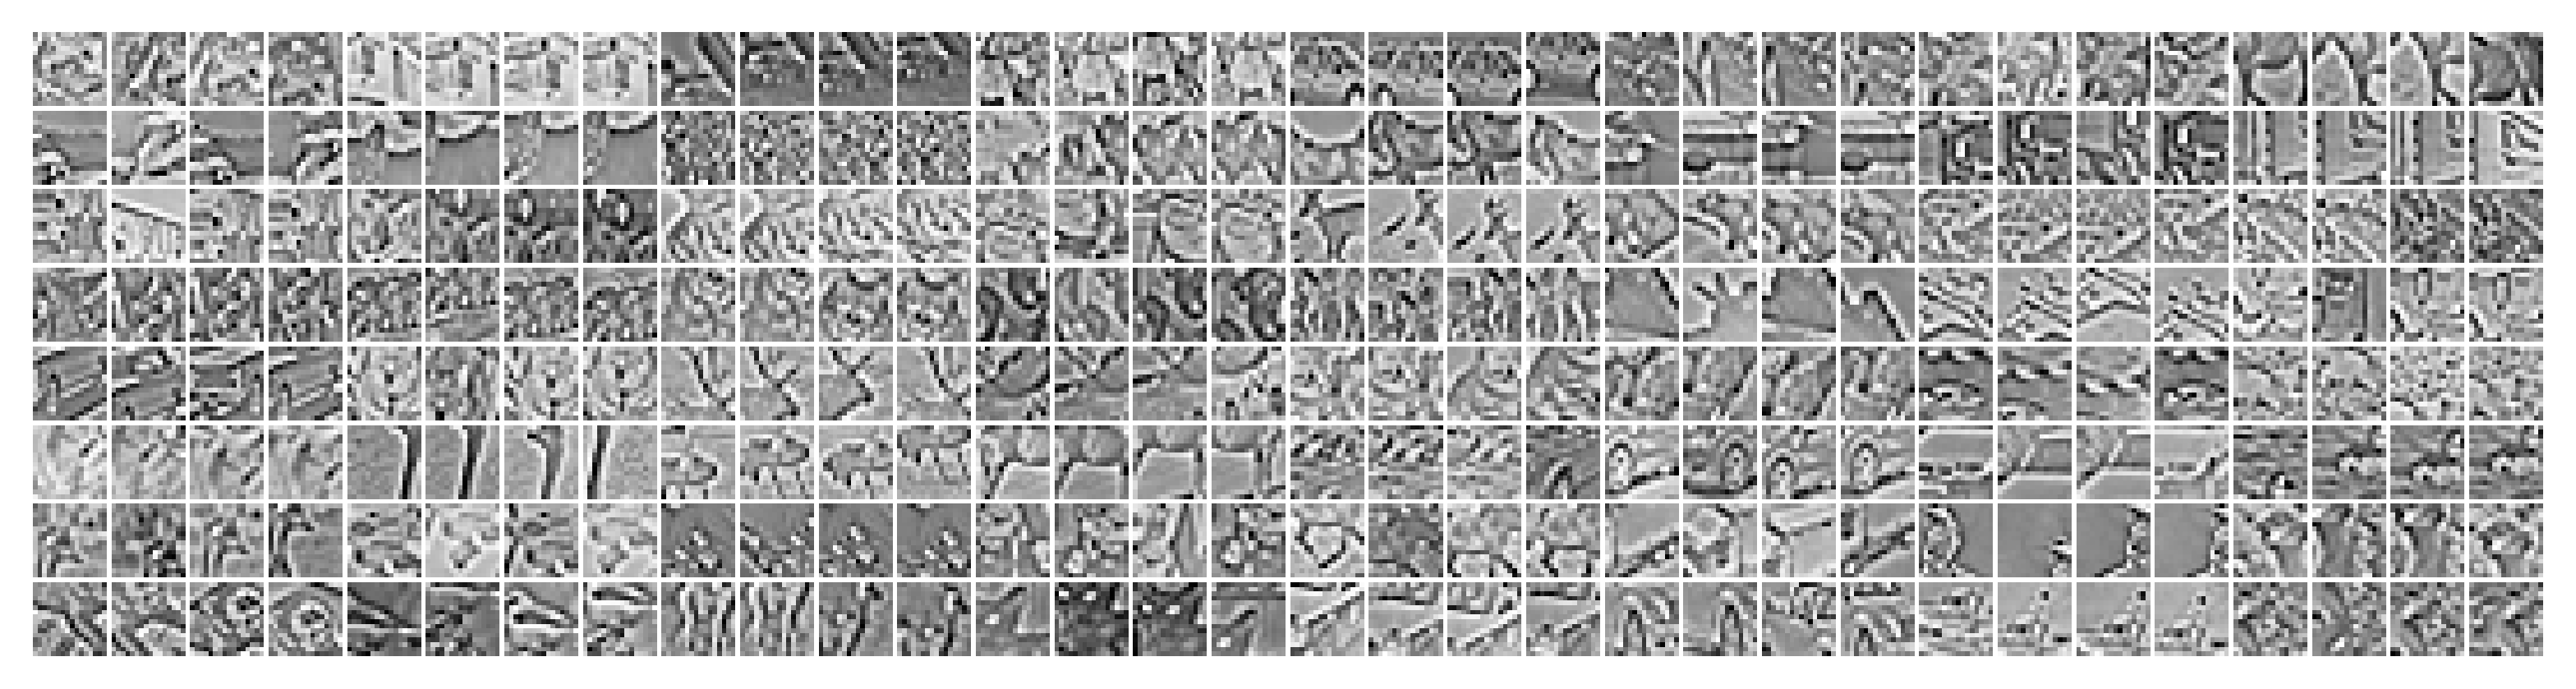

In [14]:
_ = plot_weights(trn.tensors[0][:256], nrows=8, dpi=400)

## Quick comparison to DOVES

In [15]:
trn, vld = make_dataset(
    dataset='DOVES',
    load_dir='/home/hadi/Datasets',
    device=torch.device('cuda:0'),
)

In [16]:
trn.tensors[0].shape

torch.Size([107520, 1, 16, 16])

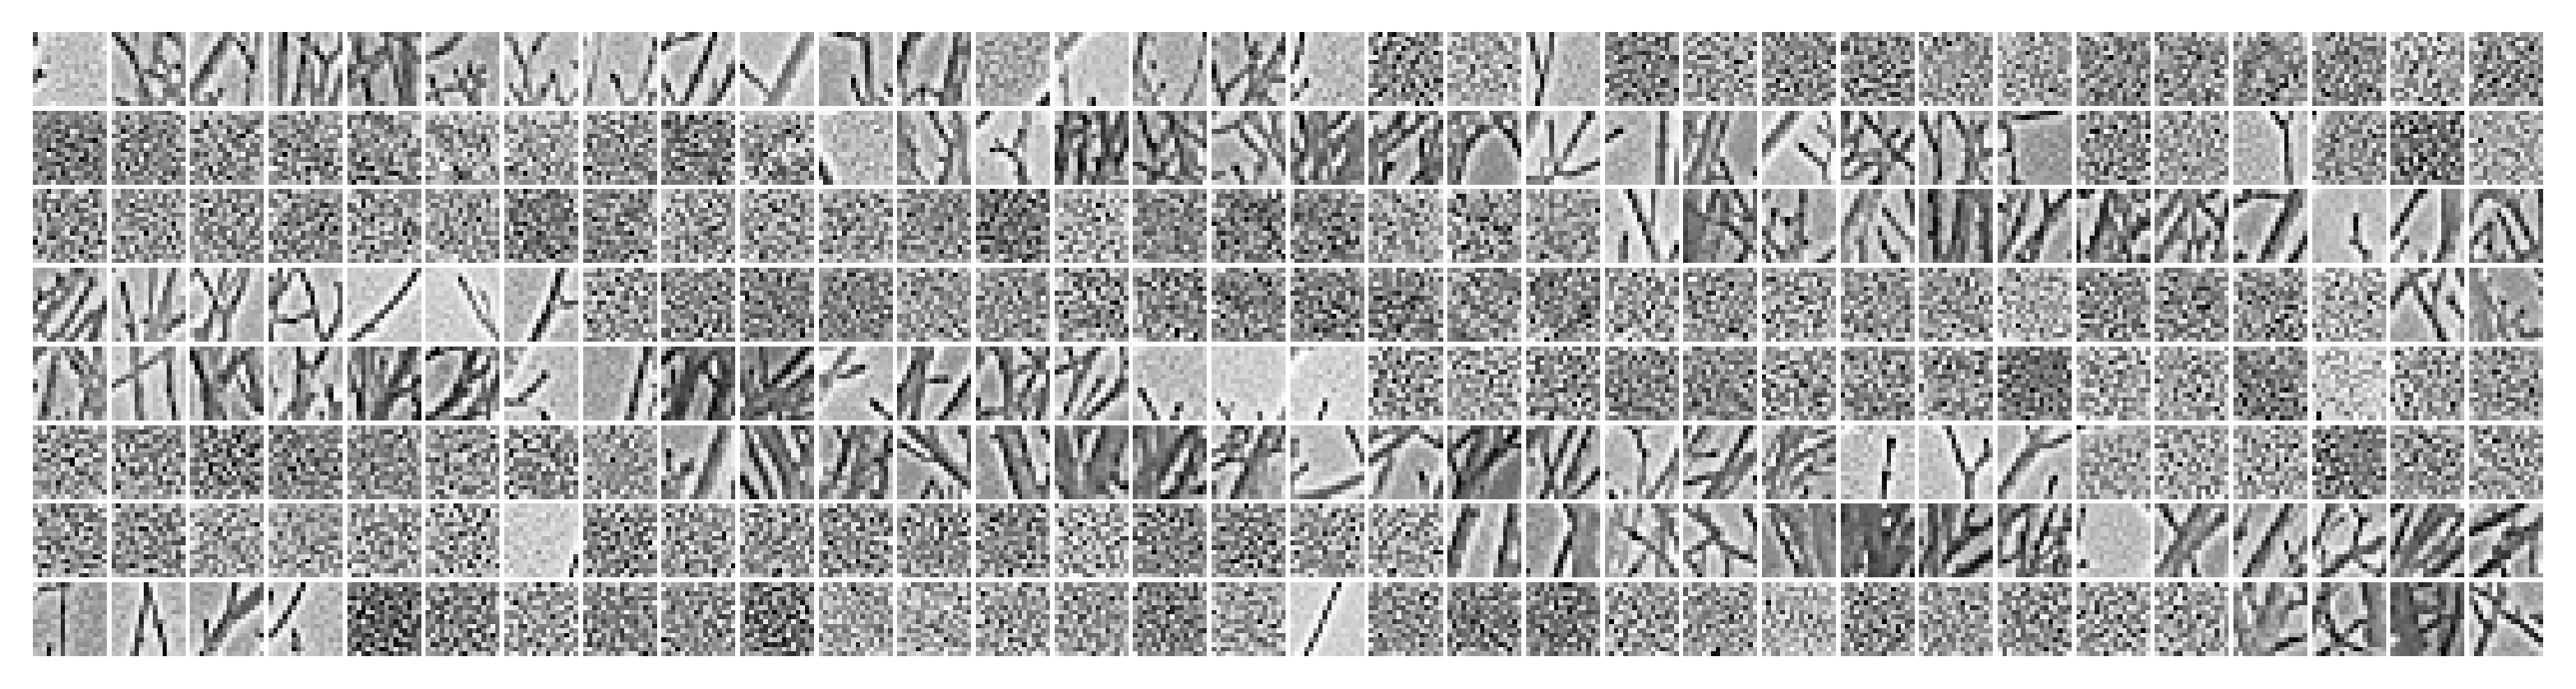

In [17]:
_ = plot_weights(trn.tensors[0][:256], nrows=8, dpi=400)

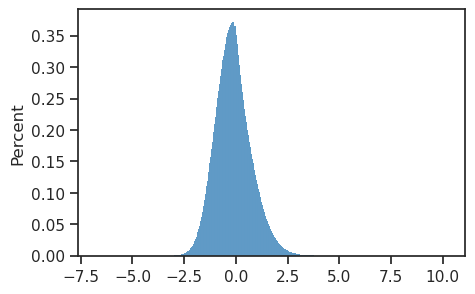

In [18]:
sns.histplot(to_np(trn.tensors[0]).ravel(), stat='percent');